# Create a diffractogram

## Imports
Import the necessary packages. We import **janssen** as `jns`. 

In [37]:
import janssen as jns
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

### Generate a random image from Numpy, to be used as the lightwave.

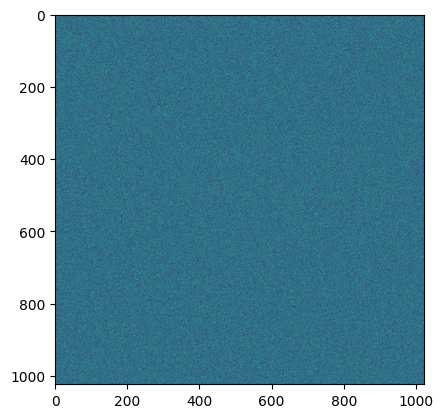

In [38]:
random_image = (np.abs(np.reshape(np.random.randn(1024**2), (1024, 1024))))**0.5
plt.imshow(random_image)

## JIT compile the function(s) to be used.

In [39]:
make_optical_wavefront = jax.jit(jns.utils.make_optical_wavefront)
make_sample_function = jax.jit(jns.utils.make_sample_function)
linear_interaction = jax.jit(jns.simul.linear_interaction)
optical_zoom = jax.jit(jns.lenses.optical_zoom)
circular_aperture = jax.jit(jns.simul.circular_aperture)
fraunhofer_prop = jax.jit(jns.lenses.fraunhofer_prop)
fresnel_prop = jax.jit(jns.lenses.fresnel_prop)
angular_spectrum_prop = jax.jit(jns.lenses.angular_spectrum_prop)


### Create the optical wavefront from the random image.

In [40]:
wavelength = 533e-9  # Fixed: should be 533e-9 meters, not 533/(10^9)
dx = 3e-4  # Fixed: should be 3e-4 meters, not 3/(10**4)
random_image = jnp.asarray(random_image, dtype=jnp.complex128)
optical_wave = make_optical_wavefront(random_image, wavelength, dx, z_position=0.0)
print(f"Wavelength: {wavelength} meters")
print(f"dx: {dx} meters")

Wavelength: 5.33e-07 meters
dx: 0.0003 meters


### Create a sample function from a sinusoidal pattern

In [41]:
im_jax = jnp.tile(jnp.sin(np.arange(start=0, stop=16*jnp.pi, step=jnp.pi/64)), (1024, 1))
random_wave = jnp.asarray(random_image, dtype=jnp.complex128)
random_wave = random_wave/jnp.max(jnp.abs(random_wave))
sample_function = make_sample_function(im_jax, dx)

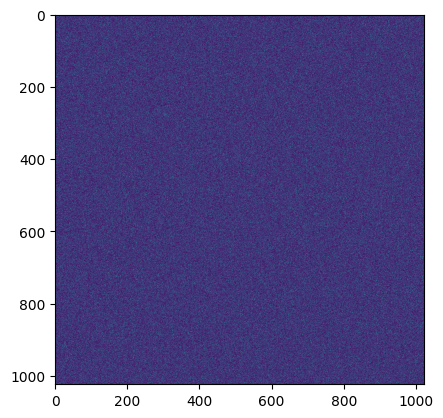

In [42]:
plt.imshow(jnp.abs(optical_wave.field)**2)

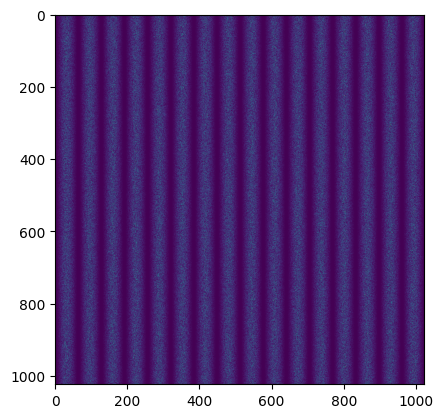

In [43]:
at_sample = linear_interaction(sample_function, optical_wave)
plt.imshow(jnp.abs(at_sample.field)**2)

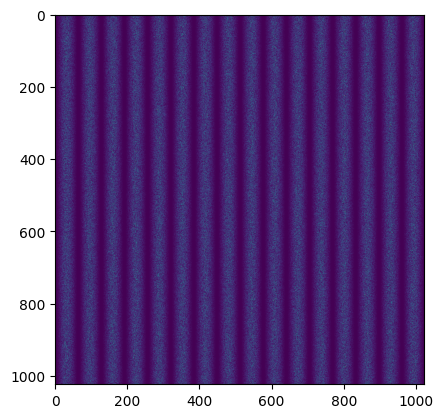

In [44]:
zoomed_wave = optical_zoom(at_sample, zoom_factor=9.7)
plt.imshow(jnp.abs(zoomed_wave.field)**2)

### Compare `dx` values. 
As you can see using `optical_zoom` changes it.

In [45]:
zoomed_wave.dx, at_sample.dx, optical_wave.dx, sample_function.dx, dx

(Array(0.00291, dtype=float64),
 Array(0.0003, dtype=float64),
 Array(0.0003, dtype=float64),
 Array(0.0003, dtype=float64),
 0.0003)

### Use a circular aperture. 
We can move the location of the aperture around too.

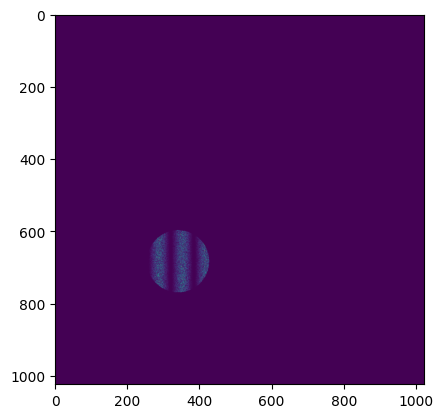

In [46]:
after_aperture = circular_aperture(zoomed_wave, diameter=0.5, center=jnp.array([-0.5, 0.5]))
plt.imshow(jnp.abs(after_aperture.field)**2)

### Propagate the beam
Use **Fraunhofer** propagation from `fraunhofer_prop` to propagate the beam. Other types available are **Fresnel** and **Angular Spectrum Propagators**.

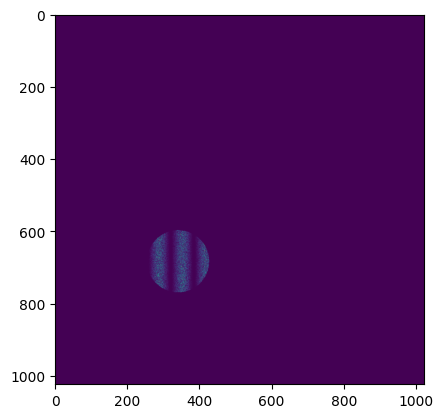

In [47]:
at_camera_fraunhofer = fraunhofer_prop(after_aperture, 0.1)
plt.imshow(jnp.abs(at_camera_fraunhofer.field)**2)

Use **Fresnel** propagation from `fresnel_prop` to propagate the beam now.

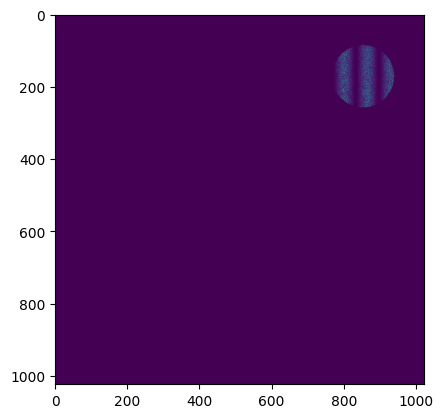

In [48]:
at_camera_fresnel = fresnel_prop(after_aperture, 0.1)
plt.imshow(jnp.abs(at_camera_fresnel.field)**2)

Use **Angular Spectrum Propagation** propagation from `angular_spectrum_prop` to propagate the beam now.

After aperture field stats:
  Wavelength: 5.33e-07
  dx (pixel size): 0.0029099999999999994
  Field shape: (1024, 1024)
  Field min/max magnitude: 0.000000, 1.900074
  Non-zero elements: 23187

Angular spectrum at z=0.001m:
  Field min/max magnitude: 0.000000, 1.900074
  Non-zero elements: 1048576

Angular spectrum at z=0.01m:
  Field min/max magnitude: 0.000000, 1.900074
  Non-zero elements: 1048576

Angular spectrum at z=0.1m:
  Field min/max magnitude: 0.000000, 1.900068
  Non-zero elements: 1048576

Angular spectrum at z=1.0m:
  Field min/max magnitude: 0.000000, 1.899464
  Non-zero elements: 1048576

Evanescent mask analysis:
  Total pixels: 1048576
  Pixels passing evanescent mask: 1048576
  Percentage passing: 100.00%
  Max spatial frequency squared: 5.90e+04
  Wavelength cutoff squared: 3.52e+12


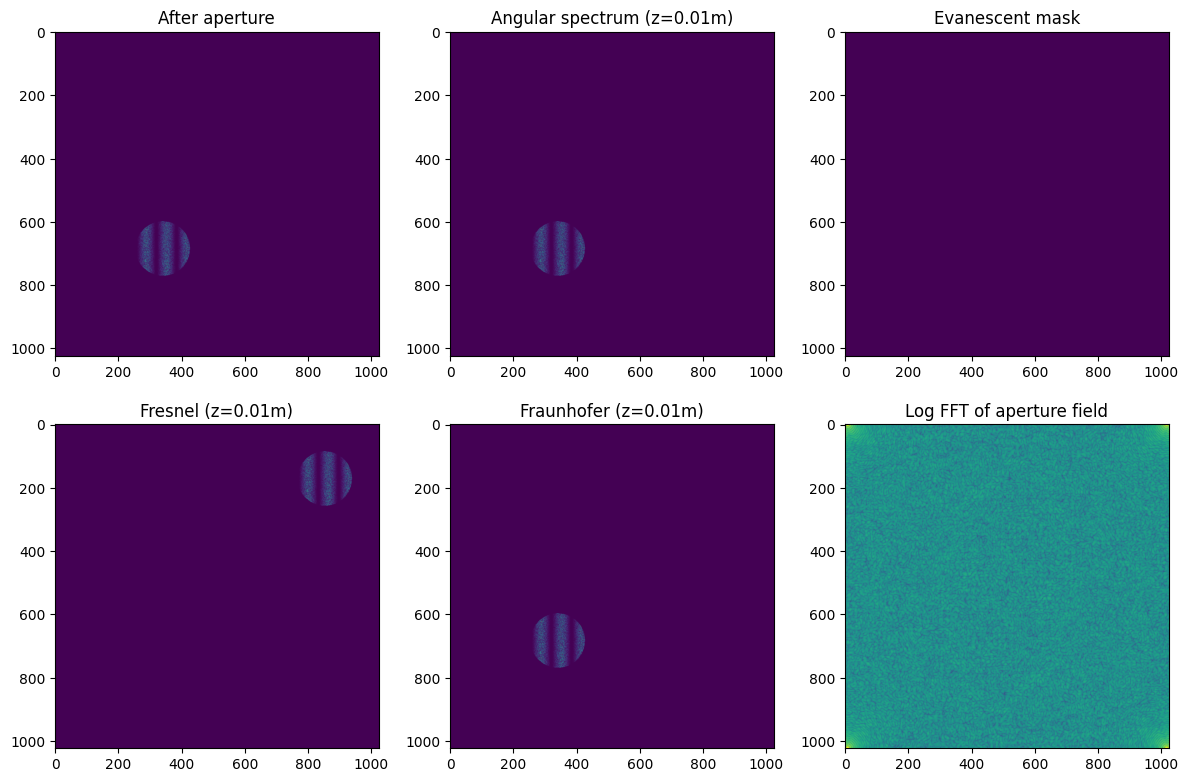

In [49]:
# Let's debug the angular spectrum propagation
print("After aperture field stats:")
print(f"  Wavelength: {after_aperture.wavelength}")
print(f"  dx (pixel size): {after_aperture.dx}")
print(f"  Field shape: {after_aperture.field.shape}")
print(f"  Field min/max magnitude: {jnp.abs(after_aperture.field).min():.6f}, {jnp.abs(after_aperture.field).max():.6f}")
print(f"  Non-zero elements: {(jnp.abs(after_aperture.field) > 0).sum()}")

# Try different distances
distances = [0.001, 0.01, 0.1, 1.0]
for z in distances:
    result = angular_spectrum_prop(after_aperture, z)
    print(f"\nAngular spectrum at z={z}m:")
    print(f"  Field min/max magnitude: {jnp.abs(result.field).min():.6f}, {jnp.abs(result.field).max():.6f}")
    print(f"  Non-zero elements: {(jnp.abs(result.field) > 0).sum()}")
    
# Let's check the evanescent mask in angular spectrum
# Recreate what happens inside angular_spectrum_prop
z_test = 0.01
ny, nx = after_aperture.field.shape
wavenumber = 2 * jnp.pi / after_aperture.wavelength
fx = jnp.fft.fftfreq(nx, d=after_aperture.dx)
fy = jnp.fft.fftfreq(ny, d=after_aperture.dx)
fx_mesh, fy_mesh = jnp.meshgrid(fx, fy)
fsq_mesh = (fx_mesh**2) + (fy_mesh**2)
evanescent_mask = (1/after_aperture.wavelength)**2 >= fsq_mesh

print(f"\nEvanescent mask analysis:")
print(f"  Total pixels: {evanescent_mask.size}")
print(f"  Pixels passing evanescent mask: {evanescent_mask.sum()}")
print(f"  Percentage passing: {100*evanescent_mask.sum()/evanescent_mask.size:.2f}%")
print(f"  Max spatial frequency squared: {fsq_mesh.max():.2e}")
print(f"  Wavelength cutoff squared: {(1/after_aperture.wavelength)**2:.2e}")

# Plot the results
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes[0,0].imshow(jnp.abs(after_aperture.field)**2)
axes[0,0].set_title('After aperture')

at_camera_angular_spectrum = angular_spectrum_prop(after_aperture, 0.01)
axes[0,1].imshow(jnp.abs(at_camera_angular_spectrum.field)**2)
axes[0,1].set_title('Angular spectrum (z=0.01m)')

axes[0,2].imshow(evanescent_mask.astype(float))
axes[0,2].set_title('Evanescent mask')

# Compare with fresnel and fraunhofer at same distance
at_camera_fresnel_01 = fresnel_prop(after_aperture, 0.01)
axes[1,0].imshow(jnp.abs(at_camera_fresnel_01.field)**2)
axes[1,0].set_title('Fresnel (z=0.01m)')

at_camera_fraunhofer_01 = fraunhofer_prop(after_aperture, 0.01)
axes[1,1].imshow(jnp.abs(at_camera_fraunhofer_01.field)**2)
axes[1,1].set_title('Fraunhofer (z=0.01m)')

# Show FFT of aperture field
field_ft = jnp.fft.fft2(after_aperture.field)
axes[1,2].imshow(jnp.log10(jnp.abs(field_ft)**2 + 1e-10))
axes[1,2].set_title('Log FFT of aperture field')

plt.tight_layout()
plt.show()

## Propagator Comparison and Validity Regions

The three propagators have different validity regions based on the Fresnel number:
- **Angular Spectrum**: Valid for all distances (most accurate, no approximations)
- **Fresnel**: Valid when Fresnel number >> 1 (near-field)  
- **Fraunhofer**: Valid when Fresnel number << 1 (far-field)

The Fresnel number is: F = a²/(λz) where a is the aperture size, λ is wavelength, z is distance

In [50]:
# Calculate Fresnel numbers and compare propagators
aperture_diameter = 0.5  # meters (from circular_aperture call)
aperture_radius = aperture_diameter / 2

# After fixing wavelength, recalculate
wavelength_correct = 533e-9  # meters
distances_to_test = jnp.logspace(-3, 1, 20)  # From 1mm to 10m

print("Fresnel number analysis:")
print("-" * 60)
for z in distances_to_test:
    fresnel_number = aperture_radius**2 / (wavelength_correct * z)
    regime = "Far-field (Fraunhofer)" if fresnel_number < 1 else "Near-field (Fresnel)" if fresnel_number < 10 else "Very near-field"
    print(f"z = {z:.3f}m: F = {fresnel_number:.2f} - {regime}")

print("\n" + "="*60)
print("For aperture diameter = 0.5m and wavelength = 533nm:")
print("="*60)

# Critical distances
z_fresnel_transition = aperture_radius**2 / (10 * wavelength_correct)  # F = 10
z_fraunhofer_transition = aperture_radius**2 / wavelength_correct  # F = 1

print(f"\nFresnel approximation valid for: z << {z_fraunhofer_transition:.1f}m")
print(f"Fraunhofer approximation valid for: z >> {z_fraunhofer_transition:.1f}m") 
print(f"Transition region: z ≈ {z_fraunhofer_transition:.1f}m")

# All three should give similar results in the Fraunhofer regime
print(f"\nAll propagators should give similar results when z > {10*z_fraunhofer_transition:.0f}m")

Fresnel number analysis:
------------------------------------------------------------
z = 0.001m: F = 117260787.99 - Very near-field
z = 0.002m: F = 72214846.51 - Very near-field
z = 0.003m: F = 44473384.04 - Very near-field
z = 0.004m: F = 27388854.00 - Very near-field
z = 0.007m: F = 16867376.74 - Very near-field
z = 0.011m: F = 10387743.79 - Very near-field
z = 0.018m: F = 6397273.43 - Very near-field
z = 0.030m: F = 3939749.40 - Very near-field
z = 0.048m: F = 2426287.62 - Very near-field
z = 0.078m: F = 1494224.89 - Very near-field
z = 0.127m: F = 920215.73 - Very near-field
z = 0.207m: F = 566713.21 - Very near-field
z = 0.336m: F = 349009.32 - Very near-field
z = 0.546m: F = 214936.76 - Very near-field
z = 0.886m: F = 132368.42 - Very near-field
z = 1.438m: F = 81518.86 - Very near-field
z = 2.336m: F = 50203.24 - Very near-field
z = 3.793m: F = 30917.58 - Very near-field
z = 6.158m: F = 19040.53 - Very near-field
z = 10.000m: F = 11726.08 - Very near-field

For aperture diamete